In [1]:
from IPython import display

# Deep Deterministic Policy Gradient (DDPG)


DDPG method uses two networks to learn the enviroment and to maximize the future reward in a system that may be controlled by means of actions represented in a continuous domain. The first network is called the Actor $A(w^a)$ (parameterized by $w^a$), this network takes the current state, of the agent, and outputs the best (according to the network) action. The second network is the called the Critic $C(w^c)$ (parameterized by $w^c$), this network is responsible to criticize the action taken by the Actor network. The ciritc network does that by taking the current state and the actions, chosen by the Actor, and outputs the q-value. The q-value indicates how favorable is would be to take the action when in the current state. 

As part of the training process of the network there are two different stages that repeats it self until the agent is deemed to have solved the enviroment

* **Enviroment Interaction**: The agent interacting with the enviroment following the recommendations made by the Actor network

* **Learn**: Updating the Actor/Critic networks using the agent's interactions


In order to facilitate the training of the networks we have two sets of weights, for each network, ($w^a$, $w^c$) and ($w^a_{\text{target}}$, $w^c_{\text{target}}$), why that is will be introduced in the "Learn" section.

 
###  Enviroment Interaction

* Choose an action using the actor network's recommendations, i.e policy, after doing inference with the current state using paramters $w_a$. When we start to train the actor network the recommendations are not going to be good (i.e. the network might have been initilzed in such a way that it always outputs approximately the same policy) and we know that we should not trust them. So instead of always following the policy, we are only going to follow it in $1 - \epsilon$ of the times, the rest of the times we are going to generate actions from a Ornstein–Uhlenbeck process. As the actor networks learns to output good policies, we decrese the $\epsilon$ until we reach $\epsilon_{end}$. Even if the network output good policies it's often favorable to have $\epsilon_{end}$ not equal to zero, making the agent continue to explore the enviroment outside of the network's current understanding about what a good policy might be. 


* As the agent interacts with the enviroment we are continuously producing states $s_t$ actions $a_t$, rewards $r_t$ (that we got after we took the action) and new states $s_{t+1}$ (when we are transitioning from $s_t$ using $a_t$). We call this collection an experience tuple ($s_t$, $a_t$, $r_t$, $s_{t+1}$). This experience tuple is stored in a buffer that is later used when performing the "Learn" step. Together with the experience tuple we also store a measurment of how much novel information that is contained within the tuple, we call this $\text{td-error}$ (it will be defined below). 


###  Learn

* Sample a batch of experience tuples from the buffer ($s_t$, $a_t$, $r_t$, $s_{t+1}$)

* Set a target for the critic network to learn, $y_t = r_t + \gamma * C(s_{t+1}, a, w^c_{\text{target}})$

The target of the action $a_t$ when in state $s_t$ then becomes a weighted sum of the immediate reward (of taking action $a_t$) and the future expected reward, if we follow a greedy policy. The discount factor $\gamma$ indicates how important future reward is compared to immediate reward in the target. When we construct the target we use $w_{\text{target}}$ to parametrize the critic network, we do this to stabilize the learning that otherwise might become unstable due to correlations between the target and the network that undergoing learning.

* Create the loss for the critic network that compares the target with the actual output from the network that undergoes learning 

$$ L_c = (C(s_t, a_t, w^c) - y_t)^2  = (C(s_t, a_t, w^c) - (r_t + \gamma * C(s_{t+1}, a, w^c_{\text{target}}))^2$$

* Create the loss for the actor network with the objective to output actions that maximize the output (q-values) from the critic

$$ L_a = - C(s_t, A(s_t, w_a), w_c) $$

During the Enviroment Interaction step, before sending an experience tuple to the replaybuffer we calculate a $\text{td-error}$, it's defined as 

$$\text{td-error} = r_t + \gamma * C(s_{t+1}, a_t+1, w^c) - C(s_{t}, a_t, w^c) $$

and gives an indication about how suprised the network was by getting reward $r_t$ and having the q-value of the following state. We can then think of $\text{td-error}$ as a proxy for how much novel information the experience tuple holds. During learning we want the network to focus on learning new things, so it makes sense to sample the tuples with high $\text{td-error}$ more frequently than those with low  $\text{td-error}$. In the replaybuffer we then set the probability of sample one tuple to be proportional to it's $\text{td-error}$. This kind of method is called Prioritized Experience Replay. Importantly, each time we use the experience tuple we update the $\text{td-error}$ in the replay buffer.
 
* Update $C(w^c)$, $A(w^a)$ by minimization of $L_a$ and $L_c$  using gradient descent. 

* Update $C(w^c_{\text{target}})$ and $A(w^a_{\text{target}})$ weights by low-pass filter 

$$w^c_{\text{target}} = \tau \times w^c_{\text{target}} + (1 - \tau) \times w^c$$

$$w^a_{\text{target}} = \tau \times w^a_{\text{target}} + (1 - \tau) \times w^a$$

# Network architecture

The networks consist of 3 hidden fully connected layers, 5 including the input and output layers. After each layer, except the output layer, layer normalization is used that normalizes the input across the nodes's output. ELU is used as activation function after each layer normalization.
   
### Critic    
   
    Fully connected - in 37 out 256  -> 256 nodes
    Layer Normalization
    ELU
    
    Fully connected - in 256 out 256 -> 256 nodes
    Layer Normalization
    ELU
    
    Fully connected - in 256 out 128 -> 128 nodes
    Layer Normalization
    ELU
    
    Fully connected - in 128 out 128  -> 128 nodes
    Layer Normalization
    ELU
    
    Fully connected - in 128 out 1   -> 1 nodes
    
    
### Actor 
    
    Fully connected - in 33 out 256  -> 256 nodes
    Layer Normalization
    ELU
    
    Fully connected - in 256 out 256 -> 256 nodes
    Layer Normalization
    ELU
    
    Fully connected - in 256 out 128 -> 128 nodes
    Layer Normalization
    ELU
    
    Fully connected - in 128 out 128  -> 128 nodes
    Layer Normalization
    ELU
    
    Fully connected - in 128 out 4   -> 1 nodes
    Hyperbolic Tangent



# Peformance

The graphs show the average score of the agent. To the right is the validation score where we always take the actions coming from the actor network. To the left is the training score where we partly take the actions coming from the actor network and partly from our noise generator according to the training scheme. 

When the #episode < 100, we calculate the average of all the available scores. 
When the #episode >= 100, we calculate the average only using the 100 most recent scores.

* After 38 episodes was an average score of +30, for both the validation and training, achieved.

* After 100 episodes was an average of +36, for both the validation and training, achieved

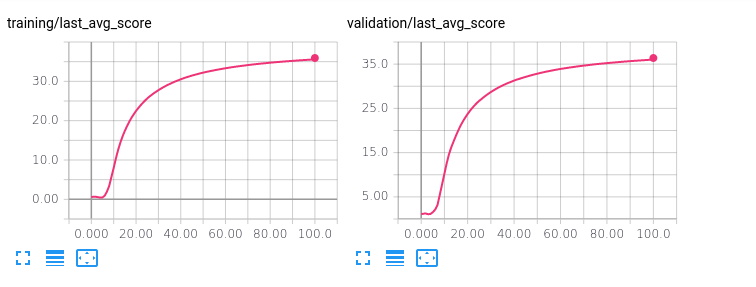

In [3]:
display.Image("img/performance.png")

The graph shows the validation score for the different episodes

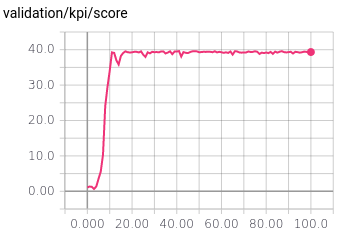

In [4]:
display.Image("img/performance_instantaneous.png")

# Hyperparameters 

The name of the experiment, as seen in tensorboard
    
    experiement_name = "final"

Size of the batches
    
    batch_size = 128

Size of the replay bufffer
    
    replay_buffer_size = int(1e6)

In the replay buffer we normalize the weights (w), associated with each replay tuplet, with the number of times (seen),
the tuplet has been used for training. We then scale (w) with (seen) -> w <- w / seen ** beta.
High beta -> we prefer to sample unseen tuples 
    
    beta = 1

In the replay buffer, after we have scaled the weights and converted it to a probability distribution (p) we scale the 
distribution, p.^beta_2. High beta_2 -> we will only sample tuples with high weight
    
    beta_2 = 2

Number of episodes used for training
    
    episodes = 2000

Gamma in the td-loss 
    
    gamma = 0.99

We have the possibility of scaling the reward with a factor
    
    scale_reward = 10

Where do you want to run the inference/training, cuda or cpu 
    
    device = "cuda"

We wait (inference_steps), for each training episode, before we update the models
    
    inference_steps = 20

When we start update the models we do that for (update_steps) 
Total number of training steps per episode (1000 / inference_steps) * update_steps
    
    update_steps = 45


We randomly, with probability sigma, choose to use action generated from our noise-generator or to use 
the output from the actor-network

    Start of sigma 
    sigma_init = 1
    decay factor
    sigma_decay = 0.86
    stop of sigma
    sigma_end = 0.1

 Ornstein–Uhlenbeck process 
 
    Ornstein–Uhlenbeck sigma 
    ou_sigma = 0.25

Number of times we are running evaluation episodes (that we average over) after each training episode
    
    eval_rounds = 100

Learning rates

    lr_critic = 10**-4
    lr_actor = 10**-4
    Controls how we are updating the target network after each training step
    tau_critic = 10**-3
    tau_actor = 10**-3

Number of output nodes in the first 2 layers
    
    hidden_dim = 256

Number of output nodes in the following hidden layers

    squeeze_dim = 128

# Future work

#### Speed up training process

* Run the batch processing in a seperat thread compared the model inference

#### Fine tuning of hyperparamters
   
* Loop over a grid of hyperparameters, use tensorboard's hyperparamter tracking tool to narrow down a better set of hyperparamters 

#### Using historical state/action information when doing the inference

* Use previous states leading up the agent's current state when doing the model inference. Also, add the actions taken during the previous steps

#### Explore on-policy
* A2C networks
